# Symbolic Conditional Music Generation with PyTorch

This notebook implements a conditional LSTM model for symbolic music generation using PyTorch.
It covers MIDI tokenization, dataset preparation, model training, and motif-based music generation.
Visualizations for training loss are included.



# Basic Summary of Approach

This model essentially takes in a input midi file, and using the LSTM model, generates a continuation based on that. The data we used to train comes from https://github.com/asigalov61/Tegridy-MIDI-Dataset/blob/master/Piano-Hands/Piano_Hands_Maker.ipynb and is called the **Piano Hands MIDI Dataset**. It contains both left and right hand splits for piano generation, so the thought process is that this would make it easier to create complex generations which can build off of a input midi file easier. 

The input is a midi file called **midi_export.mid**. This midi file is then tokenized and after training, the generation continues from this tokenized input file generating notes according to what was learned during the training section. Essentially, the generated file called **generated_piano_composition.mid** contains (midi_export.mid + _generation after training_).


In [22]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from miditok import REMI, TokenizerConfig
from midiutil import MIDIFile # Kept from original script
from glob import glob
import numpy as np
import random
import os
import matplotlib.pyplot as plt # For plotting
import traceback # For detailed error reporting

# Helper to get current directory, as __file__ is not defined in notebooks
# Assumes the notebook is in the 'Symbolic(Conditional)' directory relative to the project root.
# Adjust this path if your notebook is located elsewhere or if data paths are absolute.
try:
    # This assumes the notebook is in the intended script directory.
    script_dir = os.getcwd()
except NameError:
    # Fallback if even os.getcwd() causes issues in some exotic environment (unlikely)
    script_dir = '.'

print(f"Working directory (assumed script_dir): {script_dir}")

Working directory (assumed script_dir): c:\Users\XnavX\153R_Assignment2\Symbolic(Conditional)


## Configuration

Define hyperparameters and constants for the model, training, and data processing.

In [23]:
# Configuration
SEQ_LEN = 96
EMBED_SIZE = 100
HIDDEN_SIZE = 512
NUM_LAYERS = 2
DROPOUT = 0.25 # Adjusted
LEARNING_RATE = 0.0005
BATCH_SIZE = 128
NUM_EPOCHS = 20 # Increased for scheduler
VOCAB_SIZE = None # To be set after tokenizing
CONDITION_DIM = 10 # Will be updated by len(condition_map)
OUTPUT_MIDI_PATH = "generated_piano_composition.mid" # Changed output path

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("Configuration set.")

Configuration set.


## 1. MIDI Tokenization

Setup the MIDI tokenizer using `miditok`. We use the REMI (REvised MIDI) representation.

In [24]:
# Using REMI tokenizer configuration
TOKENIZER_CONFIG = TokenizerConfig(
    num_velocities=16, 
    use_chords=True, 
    use_tempos=True, 
    use_programs=False, 
    use_time_signatures=True,
    beat_res={(0, 4): 8, (4, 12): 4}
)
tokenizer = REMI(TOKENIZER_CONFIG)

print("Tokenizer configured.")

Tokenizer configured.


## 2. Dataset Preparation

Define the `MidiDataset` class to load, tokenize, and prepare MIDI files for training.

In [26]:
class MidiDataset(Dataset):
    def __init__(self, midi_files, tokenizer, seq_len, condition_map):
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        # All files will belong to the single "general_piano" condition
        self.general_piano_condition_label = "general_piano"
        if self.general_piano_condition_label not in condition_map:
            raise ValueError(f"'{self.general_piano_condition_label}' not found in condition_map. It should be the only key.")
        self.condition_idx = condition_map[self.general_piano_condition_label]
        
        self.all_tokens = []
        self.conditions = []

        for midi_file_path in midi_files:
            try:
                tokenized_midi_tracks = self.tokenizer(midi_file_path) # Returns a list of TokenSequence for tracks
                if not tokenized_midi_tracks:
                    print(f"Warning: Tokenizer returned empty for {midi_file_path}. Skipping.")
                    continue
                
                # Concatenate tokens from all tracks
                current_file_tokens = []
                for track_tokens in tokenized_midi_tracks:
                    current_file_tokens.extend(track_tokens.ids)
                
                if not current_file_tokens:
                    print(f"Warning: No tokens found after concatenating tracks for {midi_file_path}. Skipping.")
                    continue
                
            except Exception as e:
                print(f"Error tokenizing {midi_file_path}: {e}. Skipping.")
                continue
            
            if len(current_file_tokens) > self.seq_len:
                for i in range(0, len(current_file_tokens) - self.seq_len, self.seq_len // 2): # Overlapping sequences
                    self.all_tokens.append(current_file_tokens[i : i + self.seq_len + 1])
                    self.conditions.append(self.condition_idx) # Assign the single condition index
        
        global VOCAB_SIZE # Ensure we are updating the global VOCAB_SIZE
        if not self.tokenizer.is_trained:
            print("Warning: Tokenizer vocabulary might not be built. Ensure learn_bpe() has been called on training data.")
        VOCAB_SIZE = len(self.tokenizer)


    def __len__(self):
        return len(self.all_tokens)

    def __getitem__(self, idx):
        tokens = self.all_tokens[idx]
        condition = self.conditions[idx]
        
        x = torch.tensor(tokens[:-1], dtype=torch.long)
        y = torch.tensor(tokens[1:], dtype=torch.long)
        c = torch.tensor(condition, dtype=torch.long) # Condition as a tensor
        return x, y, c

print("MidiDataset class defined.")

MidiDataset class defined.


## 3. Model Definition

Define the `ConditionalLSTM` model architecture. This LSTM takes token embeddings and condition embeddings as input.

In [27]:
class ConditionalLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, condition_dim):
        super(ConditionalLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Embedding for the condition
        self.condition_embedding = nn.Embedding(condition_dim, embed_size) 
        
        # LSTM input size will be embed_size (for token) + embed_size (for condition)
        self.lstm = nn.LSTM(embed_size * 2, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, c, h=None):
        # x shape: (batch_size, seq_len)
        # c shape: (batch_size) - condition index for each sequence in the batch
        
        embedded_x = self.embedding(x) # (batch_size, seq_len, embed_size)
        embedded_c = self.condition_embedding(c) # (batch_size, embed_size)
        
        # Expand condition embedding to match sequence length
        # embedded_c shape: (batch_size, embed_size) -> (batch_size, 1, embed_size)
        embedded_c_expanded = embedded_c.unsqueeze(1).repeat(1, x.size(1), 1) # (batch_size, seq_len, embed_size)
        
        # Concatenate token embedding and condition embedding
        combined_input = torch.cat((embedded_x, embedded_c_expanded), dim=2) # (batch_size, seq_len, embed_size * 2)
        
        out, h = self.lstm(combined_input, h)
        out = self.dropout(out)
        out = self.fc(out) # (batch_size, seq_len, vocab_size)
        return out, h

print("ConditionalLSTM class defined.")

ConditionalLSTM class defined.


## 4. Training Loop

Define the `train_model` function. This function is modified to:
- Use the global `script_dir` (defined in the first Python cell) for the stop flag path.
- Collect and return epoch-wise and batch-wise loss values for later visualization.

In [28]:
# train_model function now uses global script_dir and returns losses
def train_model(model, dataloader, num_epochs, learning_rate, device, current_script_dir):
    if VOCAB_SIZE is None or VOCAB_SIZE == 0: # Added check for VOCAB_SIZE == 0
        print("Error: VOCAB_SIZE not set or is zero. Tokenize data first.")
        return [], [] # Return empty lists for losses

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=10)
    
    # stop_file_path uses the passed current_script_dir
    stop_file_path = os.path.join(current_script_dir, "STOP_TRAINING.flag")

    model.to(device)
    model.train()

    epoch_losses_history = []
    batch_losses_history = []

    print(f"Starting training for {num_epochs} epochs on {device}...")
    print(f"To manually stop training, create an empty file named 'STOP_TRAINING.flag' in the directory: {current_script_dir}")

    training_stopped_manually = False
    for epoch in range(num_epochs):
        if os.path.exists(stop_file_path):
            print(f"Stop file '{stop_file_path}' detected. Stopping training.")
            try:
                os.remove(stop_file_path)
            except OSError as e:
                print(f"Warning: Could not remove stop file '{stop_file_path}': {e}")
            training_stopped_manually = True
            break

        total_loss = 0
        for batch_idx, (x, y, c) in enumerate(dataloader):
            x, y, c = x.to(device), y.to(device), c.to(device)
            
            optimizer.zero_grad()
            output, _ = model(x, c)
            
            loss = criterion(output.reshape(-1, VOCAB_SIZE), y.reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            batch_losses_history.append(loss.item())

            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

        if training_stopped_manually:
            break

        avg_loss = total_loss / len(dataloader)
        epoch_losses_history.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_loss:.4f}")
        scheduler.step(avg_loss)

    if not training_stopped_manually and os.path.exists(stop_file_path):
        print(f"Stop file '{stop_file_path}' detected after training loop. Cleaning up.")
        try:
            os.remove(stop_file_path)
        except OSError as e:
            print(f"Warning: Could not remove stop file '{stop_file_path}': {e}")
            
    if training_stopped_manually:
        print("Training was manually stopped.")
    else:
        print("Training finished.")
        
    return epoch_losses_history, batch_losses_history

print("train_model function defined.")

train_model function defined.


## 5. Music Generation

Define the `generate_music` function to produce new musical sequences based on a starting motif and a condition.

In [30]:
def generate_music(model, tokenizer, start_tokens, condition_idx, max_len, device, temperature=1.0, top_p=0.0):
    if VOCAB_SIZE is None or VOCAB_SIZE == 0:
        print("Error: VOCAB_SIZE not set or is zero. Train model or load vocab first.")
        return None

    model.to(device)
    model.eval()
    
    generated_tokens = list(start_tokens)
    current_tokens_tensor = torch.tensor([start_tokens], dtype=torch.long).to(device)
    condition_tensor = torch.tensor([condition_idx], dtype=torch.long).to(device)

    hidden = None

    print(f"Generating music with condition index: {condition_idx}, temp: {temperature}, top_p: {top_p}...")
    with torch.no_grad():
        for _ in range(max_len - len(start_tokens)):
            if current_tokens_tensor.size(1) > SEQ_LEN:
                 input_seq = current_tokens_tensor[:, -SEQ_LEN:]
            else:
                 input_seq = current_tokens_tensor

            output, hidden = model(input_seq, condition_tensor, hidden)
            logits = output[:, -1, :] / temperature

            if top_p > 0.0 and top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits_clone = logits.clone() 
                logits_clone[0, indices_to_remove] = -float('Inf')
                probabilities = torch.softmax(logits_clone, dim=-1)
            else:
                probabilities = torch.softmax(logits, dim=-1)
            
            next_token = torch.multinomial(probabilities, 1).item()
            generated_tokens.append(next_token)
            current_tokens_tensor = torch.cat((current_tokens_tensor, torch.tensor([[next_token]], dtype=torch.long).to(device)), dim=1)

            if hasattr(tokenizer, 'id_to_token') and next_token in tokenizer.id_to_token:
                if tokenizer.id_to_token[next_token] == "EOS_None":
                    print("End of sequence token generated.")
                    break
            elif hasattr(tokenizer, 'vocab') and isinstance(tokenizer.vocab, list) and next_token < len(tokenizer.vocab):
                if tokenizer.vocab[next_token] == "EOS_None":
                    print("End of sequence token generated (via list vocab).")
                    break
                
    return generated_tokens

print("generate_music function defined.")

generate_music function defined.


## 6. Main Execution: Setup

Initialize device, condition mapping, and paths for data.
The `script_dir` variable (defined in the first Python cell) is used to construct paths relative to the notebook's location.

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Simplified condition map for a single "general_piano" style
condition_map = {
    "general_piano": 0,
}
CONDITION_DIM = len(condition_map) # This will be 1
print(f"Condition map: {condition_map}, Dimension: {CONDITION_DIM}")

# All files in this folder will be treated as "general_piano".
# Uses the global script_dir defined earlier
base_data_path = os.path.join(script_dir, "piano_data")
print(f"Base data path for training MIDI files: {base_data_path}")

# Load .mid files recursively from the piano_data folder and its subdirectories
training_midi_files = []
if os.path.isdir(base_data_path):
    for root, dirs, files in os.walk(base_data_path):
        for file in files:
            if file.endswith(".mid") or file.endswith(".midi"):
                training_midi_files.append(os.path.join(root, file))
else:
    print(f"Warning: Base data path does not exist or is not a directory: {base_data_path}")


if not training_midi_files:
    print(f"No MIDI files found recursively in {base_data_path}. Please check the path and ensure MIDI files are present.")
    # Training will be skipped if no files are found.
else:
    print(f"Found {len(training_midi_files)} MIDI files for training in {base_data_path}.")

Using device: cuda
Condition map: {'general_piano': 0}, Dimension: 1
Base data path for training MIDI files: c:\Users\XnavX\153R_Assignment2\Symbolic(Conditional)\piano_data
Found 5388 MIDI files for training in c:\Users\XnavX\153R_Assignment2\Symbolic(Conditional)\piano_data.


### Main Execution: Tokenizer Training/Loading

Train the tokenizer on the dataset if it hasn't been trained, or load an existing tokenizer configuration.
The vocabulary size (`VOCAB_SIZE`) is determined here.

In [32]:
# Ensure VOCAB_SIZE is reset if re-running this cell
VOCAB_SIZE = None 

if not tokenizer.is_trained and training_midi_files:
    print("Tokenizer vocabulary seems empty or not trained, learning BPE from training files...")
    print("This might take a while...")
    tokenizer.learn_bpe(vocab_size=1000, files_paths=training_midi_files) 
    VOCAB_SIZE = len(tokenizer)
elif tokenizer.is_trained:
    VOCAB_SIZE = len(tokenizer)
    print("Tokenizer is already trained.")
else: # No training files and tokenizer not trained
    print("Warning: Tokenizer is not trained and no training files found. VOCAB_SIZE will be 0.")
    VOCAB_SIZE = 0


if VOCAB_SIZE == 0 and not training_midi_files:
     print("Error: Tokenizer vocabulary is empty and no training files to learn from. Cannot proceed with model initialization.")
     # raise RuntimeError("Tokenizer vocabulary is empty and no training files. Cannot proceed.") # Option to stop execution
elif VOCAB_SIZE == 0 and training_midi_files:
    print("Error: Tokenizer vocabulary is still empty even after attempting to learn BPE. Check training files and tokenizer.")
    # raise RuntimeError("Tokenizer vocabulary is still empty after BPE. Check data.") # Option to stop execution
    
if VOCAB_SIZE is not None:
    print(f"Vocabulary size: {VOCAB_SIZE}")
else:
    print("Error: VOCAB_SIZE was not set. This indicates an issue in the tokenizer loading/training logic.")
    # raise RuntimeError("VOCAB_SIZE not set.")

Tokenizer vocabulary seems empty or not trained, learning BPE from training files...
This might take a while...


C:\Users\XnavX\AppData\Local\Temp\ipykernel_40772\2979896883.py:7: UserWarning: miditok: The `learn_bpe` method had been renamed `train`. It is now depreciated and will be removed in future updates.
  tokenizer.learn_bpe(vocab_size=1000, files_paths=training_midi_files)


Tokenizer vocabulary seems empty or not trained, learning BPE from training files...
This might take a while...


C:\Users\XnavX\AppData\Local\Temp\ipykernel_40772\2979896883.py:7: UserWarning: miditok: The `learn_bpe` method had been renamed `train`. It is now depreciated and will be removed in future updates.
  tokenizer.learn_bpe(vocab_size=1000, files_paths=training_midi_files)


Vocabulary size: 1000


### Token Count Distribution in Training Data

The following histogram displays the distribution of token counts across all MIDI files in the training dataset. This helps in understanding the typical length of sequences the model is trained on and can inform choices for `SEQ_LEN` or identify outliers in the dataset.

Analyzing token counts for 5388 training MIDI files...


Analyzing token counts for 5388 training MIDI files...


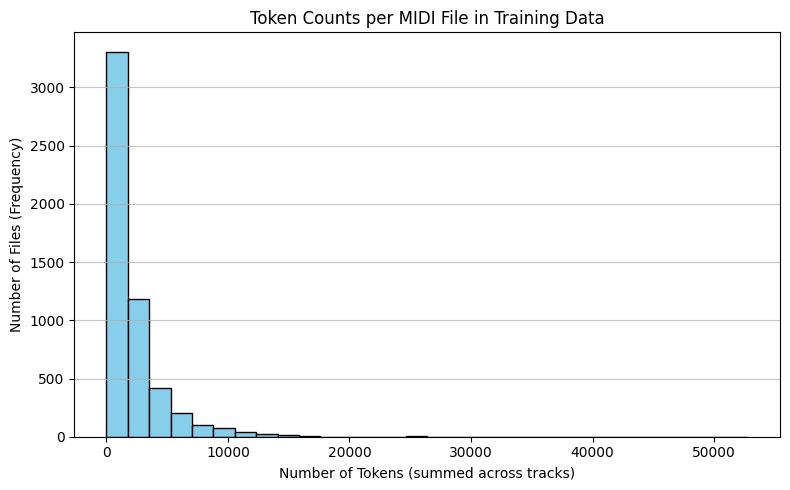

Token count statistics: Min=13, Max=52775, Avg=2158.45, Median=1311.5


In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure training_midi_files and tokenizer are defined and populated from previous cells.
if 'training_midi_files' in globals() and training_midi_files and 'tokenizer' in globals() and tokenizer.is_trained:
    note_counts = []
    print(f"Analyzing token counts for {len(training_midi_files)} training MIDI files...")
    for midi_path in training_midi_files:
        try:
            # Tokenise the whole file (list of TokenSequence, one per track)
            tokenised_tracks = tokenizer(midi_path)
            if not tokenised_tracks:
                print(f"Skipping {midi_path}: Tokenizer returned empty list.")
                continue
            # Sum the lengths of all tracks inside the file
            total_tokens = sum(len(ts.ids) for ts in tokenised_tracks)
            if total_tokens == 0:
                print(f"Skipping {midi_path}: No tokens found after tokenization.")
                continue
            note_counts.append(total_tokens)
        except Exception as e:
            print(f"Skipping {midi_path} due to error: {e}")
            # traceback.print_exc() # Uncomment for detailed error

    if note_counts:
        plt.figure(figsize=(8, 5)) # Adjusted size for better readability
        plt.hist(note_counts, bins=30, color='skyblue', edgecolor='black') # 30-bin histogram
        plt.title("Token Counts per MIDI File in Training Data")
        plt.xlabel("Number of Tokens (summed across tracks)")
        plt.ylabel("Number of Files (Frequency)")
        plt.grid(axis='y', alpha=0.75)
        plt.tight_layout()
        plt.show()
        print(f"Token count statistics: Min={np.min(note_counts)}, Max={np.max(note_counts)}, Avg={np.mean(note_counts):.2f}, Median={np.median(note_counts)}")
    else:
        print("No token counts collected – check tokenizer, file list, or individual file processing.")
else:
    print("Skipping token count histogram: `training_midi_files` list not found/empty, `tokenizer` not found, or tokenizer not trained.")

### Main Execution: Dataset and DataLoader

Create the `MidiDataset` instance and the `DataLoader` for training.

In [10]:
dataset = None
dataloader = None

if VOCAB_SIZE is not None and VOCAB_SIZE > 0 :
    dataset = MidiDataset(training_midi_files, tokenizer, SEQ_LEN, condition_map)
    if len(dataset) == 0 and training_midi_files:
        print("Training dataset is empty despite having MIDI files. Check MIDI processing, tokenization, and sequence length.")
    elif not training_midi_files:
        print("No training files, so dataset is empty. Model training will be skipped.")
    
    if dataset and len(dataset) > 0:
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        print(f"Dataset created with {len(dataset)} samples. DataLoader ready.")
    else:
        print("Dataset is empty or could not be created. DataLoader not initialized. Training will be skipped.")
else:
    print("VOCAB_SIZE is 0 or not set. Skipping Dataset and DataLoader creation.")


Dataset created with 234149 samples. DataLoader ready.


### Main Execution: Model Initialization

Initialize the `ConditionalLSTM` model.

In [11]:
model = None
if VOCAB_SIZE is not None and VOCAB_SIZE > 0:
    model = ConditionalLSTM(VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT, CONDITION_DIM)
    print("Model initialized:")
    print(model)
else:
    print("VOCAB_SIZE is 0 or not set. Skipping model initialization.")

Model initialized:
ConditionalLSTM(
  (embedding): Embedding(1000, 100)
  (condition_embedding): Embedding(1, 100)
  (lstm): LSTM(200, 512, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=512, out_features=1000, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Main Execution: Model Training

Train the model if data is available. The `train_model` function will return loss histories.

In [ ]:
epoch_losses_history = []
batch_losses_history = []

if dataloader and model and len(dataset) > 0: # Check model is initialized too
    print("Starting model training...")
    # Pass script_dir to train_model for the stop flag path
    epoch_losses_history, batch_losses_history = train_model(model, dataloader, NUM_EPOCHS, LEARNING_RATE, device, script_dir)
    
    # Consider saving the trained model:
    # model_save_path = os.path.join(script_dir, "trained_piano_model.pth") # Save in script_dir
    # torch.save(model.state_dict(), model_save_path)
    # print(f"Trained model saved to {model_save_path}")
else:
    print("Skipping training as no data is available, dataset is empty, or model not initialized.")
    # If you have a pre-trained model, load it here:
    # model_load_path = os.path.join(script_dir, "trained_piano_model.pth")
    # if os.path.exists(model_load_path) and model: # Check model is initialized
    #     print(f"Loading pre-trained model from {model_load_path}")
    #     model.load_state_dict(torch.load(model_load_path))
    #     model.to(device)
    # else:
    #     print(f"Pre-trained model not found at {model_load_path} or model not initialized.")

# print("Skipping training for now. Ensure you have a trained model or uncomment training block.")

Starting model training...
Starting training for 20 epochs on cuda...
To manually stop training, create an empty file named 'STOP_TRAINING.flag' in the directory: c:\Users\XnavX\153R_Assignment2\Symbolic(Conditional)
Starting training for 20 epochs on cuda...
To manually stop training, create an empty file named 'STOP_TRAINING.flag' in the directory: c:\Users\XnavX\153R_Assignment2\Symbolic(Conditional)
Epoch [1/20], Batch [1/1830], Loss: 6.9129
Epoch [1/20], Batch [1/1830], Loss: 6.9129
Epoch [1/20], Batch [11/1830], Loss: 5.7809
Epoch [1/20], Batch [11/1830], Loss: 5.7809
Epoch [1/20], Batch [21/1830], Loss: 5.7284
Epoch [1/20], Batch [21/1830], Loss: 5.7284
Epoch [1/20], Batch [31/1830], Loss: 5.6284
Epoch [1/20], Batch [31/1830], Loss: 5.6284
Epoch [1/20], Batch [41/1830], Loss: 5.7081
Epoch [1/20], Batch [41/1830], Loss: 5.7081
Epoch [1/20], Batch [51/1830], Loss: 5.6119
Epoch [1/20], Batch [51/1830], Loss: 5.6119
Epoch [1/20], Batch [61/1830], Loss: 5.6662
Epoch [1/20], Batch [61

### Main Execution: Training Visualization

Plot the training loss if training was performed and loss history is available.

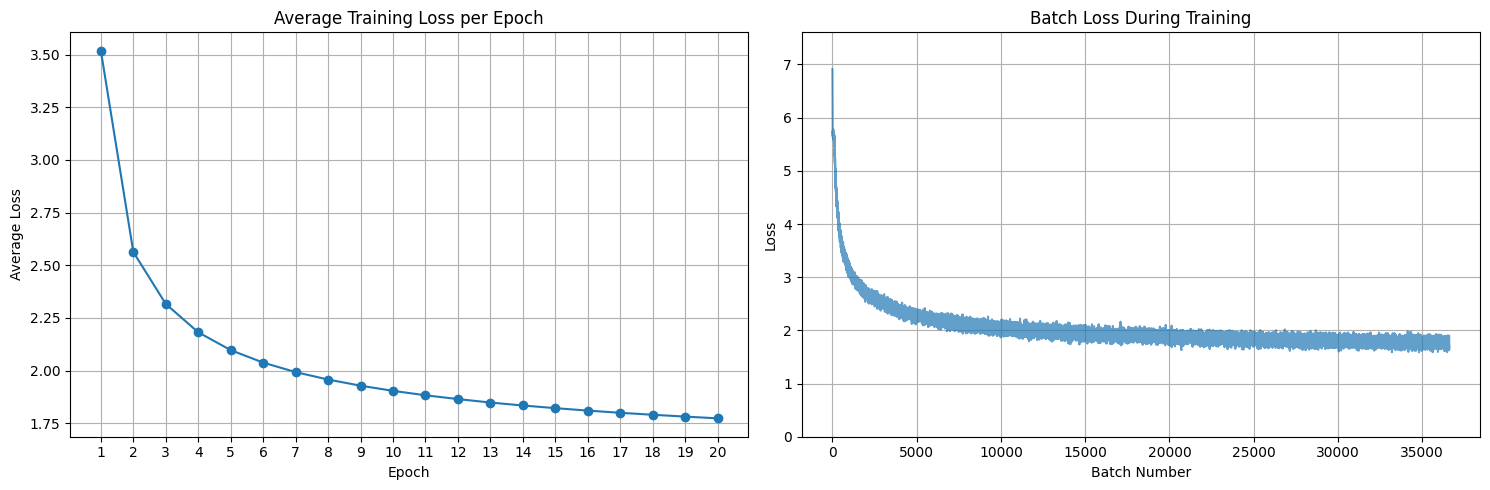

In [13]:
if epoch_losses_history: # Check if list is not empty
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(epoch_losses_history) + 1), epoch_losses_history, marker='o', linestyle='-')
    plt.title('Average Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.xticks(range(1, len(epoch_losses_history) + 1))


    if batch_losses_history: # Check if list is not empty
        plt.subplot(1, 2, 2)
        # Smooth batch losses for better visualization (e.g., moving average)
        # For simplicity, plotting raw batch losses here.
        # Consider adding a moving average for a smoother curve if needed.
        # N = 100 # Window size for moving average
        # smoothed_batch_losses = np.convolve(batch_losses_history, np.ones(N)/N, mode='valid')
        # plt.plot(smoothed_batch_losses, alpha=0.7)
        plt.plot(batch_losses_history, alpha=0.7)
        plt.title('Batch Loss During Training')
        plt.xlabel('Batch Number')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.ylim(0, max(batch_losses_history) * 1.1) # Adjust y-limit if needed

    plt.tight_layout()
    plt.show()
else:
    print("No training was performed or loss history is unavailable, skipping plotting.")

## Conclusions For These Graphs

Both graphs appear to converge to around the 1.8 mark and have the same trend of decreasing until reaching that point. The model seems to fit well to the data set.

### Main Execution: Motif Definition and Generation Setup

Define the path to a motif MIDI file. This motif will be used as a starting point for music generation.

In [ ]:
print("\n--- Motif-Based Piano Generation ---")

# This file should be a short piano piece you want the model to continue.
# It should be located in a place accessible by the script.
# For example, you could place it in the `piano_data` folder or elsewhere.
# Uses the global script_dir
motif_midi_file_path = os.path.join(script_dir, "midi_export.mid") 
# motif_midi_file_path = "c:/path/to/your/chosen/motif.mid" # Or an absolute path

print(f"Attempting to load motif from: {motif_midi_file_path}")
print("User: Please ensure this path points to your desired piano motif MIDI file.")

motif_tokens = []
if os.path.exists(motif_midi_file_path):
    try:
        if VOCAB_SIZE is None or VOCAB_SIZE == 0: # Check if tokenizer is ready
             print("Warning: VOCAB_SIZE is not set or is zero. Motif tokenization might fail or be incorrect.")
        
        motif_token_sequences = tokenizer(motif_midi_file_path) # Returns a list of TokenSequence
        if motif_token_sequences:
            for track_tokens in motif_token_sequences:
                motif_tokens.extend(track_tokens.ids)
            
            if motif_tokens:
                print(f"Motif loaded and tokenized into {len(motif_tokens)} tokens (from all tracks).")
                # print(f"Motif events: {tokenizer.ids_to_events(motif_tokens)}") # Can be verbose
            else:
                print(f"Warning: No tokens found after concatenating tracks for motif MIDI: {motif_midi_file_path}")
        else:
            print(f"Warning: Could not tokenize motif MIDI file (tokenizer returned empty): {motif_midi_file_path}")
    except Exception as e:
        print(f"Error loading or tokenizing motif MIDI '{motif_midi_file_path}': {e}")
        traceback.print_exc()
else:
    print(f"Motif MIDI file not found at: {motif_midi_file_path}. Please provide a valid path.")

if not motif_tokens:
    print("Motif is empty or could not be loaded. Using a default short sequence for demonstration.")
    if dataset and len(dataset) > 0: # Try to get from dataset if available
         sample_x, _, _ = dataset[0]
         motif_tokens = sample_x[:10].tolist() 
         if tokenizer.is_trained and VOCAB_SIZE > 0:
             print(f"Using fallback motif from dataset sample: {tokenizer.ids_to_events(motif_tokens)}")
         else:
             print(f"Using fallback motif from dataset sample (raw tokens): {motif_tokens}")
    elif VOCAB_SIZE is not None and VOCAB_SIZE > 4 and tokenizer.is_trained: # Absolute fallback if tokenizer has some known tokens
        default_event_tokens = ["Bar_None", "Position_1/16", "Pitch_60", "Velocity_80", "Duration_1.0"]
        motif_tokens = [tokenizer.token_to_id(t) for t in default_event_tokens if t in tokenizer._vocab_base.tokens_to_ids] # Check existence
        if not motif_tokens or len(motif_tokens) < 2 :
             motif_tokens = [0,1,2,3,4] if VOCAB_SIZE > 4 else [] 
        print(f"Using absolute fallback motif tokens: {motif_tokens}")
    else:
        print("Cannot create a fallback motif as tokenizer vocabulary is too small/untrained or dataset is empty.")
        motif_tokens = [] # Ensure it's an empty list

# The style for generation will be "general_piano"
target_style_label = "general_piano"
target_style_idx = condition_map.get(target_style_label) 

if target_style_idx is None:
    print(f"Error: The target style '{target_style_label}' is not in the condition_map. Defaulting to 0.")
    target_style_idx = 0 

print(f"Will attempt to continue motif in style: {target_style_label} (index: {target_style_idx})")

if len(motif_tokens) < 2:
    print("Warning: Motif tokens length is less than 2, which might not be musically meaningful for generation.")



--- Motif-Based Piano Generation ---
Attempting to load motif from: c:\Users\XnavX\153R_Assignment2\Symbolic(Conditional)\midi_export.mid
User: Please ensure this path points to your desired piano motif MIDI file.
Motif loaded and tokenized into 58 tokens (from all tracks).
Will attempt to continue motif in style: general_piano (index: 0)


### Main Execution: Music Generation from Motif

Generate a musical continuation from the loaded (or fallback) motif.

In [15]:
generated_tokens_continuation = []
if model and len(motif_tokens) > 0 and VOCAB_SIZE is not None and VOCAB_SIZE > 0: # Check model and vocab
    print("Generating music continuation for the loaded motif...")
    generated_tokens_continuation = generate_music(model, 
                                                  tokenizer, 
                                                  motif_tokens,
                                                  target_style_idx, 
                                                  max_len=len(motif_tokens) + 500, # Generate 500 tokens *after* the motif
                                                  device=device, 
                                                  temperature=1.0, 
                                                  top_p=0.8)
else:
    print("Skipping music generation: Model not initialized, no valid motif tokens, or vocabulary empty.")

if generated_tokens_continuation:
    print(f"Generated {len(generated_tokens_continuation)} total tokens (motif + continuation).")
else:
    print("No tokens were generated.")

Generating music continuation for the loaded motif...
Generating music with condition index: 0, temp: 1.0, top_p: 0.8...
Generated 558 total tokens (motif + continuation).
Generated 558 total tokens (motif + continuation).


### Main Execution: Save Generated Music

Save the generated sequence (motif + continuation) as a MIDI file.

In [16]:
if generated_tokens_continuation: 
    try:
        generated_score = tokenizer.tokens_to_midi([generated_tokens_continuation])
        
        # Save in the script's directory using global script_dir and OUTPUT_MIDI_PATH
        save_path = os.path.join(script_dir, OUTPUT_MIDI_PATH) 

        generated_score.dump_midi(save_path)
        print(f"Generated motif-based piano MIDI saved to {save_path}")

    except Exception as e:
        print(f"Error during MIDI file creation using miditok: {e}")
        traceback.print_exc()
        print(f"Generated tokens were (first 100): {generated_tokens_continuation[:100]}") # Print part of tokens for debugging
else:
    print("No tokens generated or motif generation failed, skipping MIDI file creation.")

print("\nDone.")

Generated motif-based piano MIDI saved to c:\Users\XnavX\153R_Assignment2\Symbolic(Conditional)\generated_piano_composition.mid

Done.


C:\Users\XnavX\AppData\Local\Temp\ipykernel_4896\700859254.py:3: UserWarning: miditok: The `tokens_to_midi` method had been renamed `decode`. It is now depreciated and will be removed in future updates.
  generated_score = tokenizer.tokens_to_midi([generated_tokens_continuation])
